In [55]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../rule_lib')
sys.path.insert(1, '../../../notes/1-Testing/fuzzy-test/python/')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [56]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../tuning-results-pause-during-examples/data-wsl2/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:

    files = os.listdir(directory)
    for file in files:
        if "liveInfoLogger" in file:
            liveInfo = pd.read_csv(directory + "/" + file)
            liveInfo = liveInfo.dropna()
        if "tuningData" in file:
            tuningData = pd.read_csv(directory + "/" + file)
            tuningData = tuningData.dropna()
        if "tuningResults" in file:
            tuningResults = pd.read_csv(directory + "/" + file)
            tuningResults = tuningResults.dropna()

    # filter rows where NaN is present

    tuning_iterations = tuningData["Iteration"]

    corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
        tuning_iterations)]

    assert len(corresponding_liveInfo) == len(
        tuningData), "Length of liveInfo and tuningData does not match"

    # strip columns
    corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
    tuningData.columns = tuningData.columns.str.strip()

    # convert tuningData timings into percentages
    maxTime = tuningData["Reduced"].max()
    corresponding_liveInfo.insert(1, "PerformancePercentage", (
        tuningData["Reduced"] / maxTime) * 100)

    # merge container and Data Layout
    tuningData["Container_DataLayout"] = tuningData["Container"] + \
        "_" + tuningData["Data Layout"]

    tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

    dataPairs.append((corresponding_liveInfo, tuningData))

In [57]:
X1, y1 = dataPairs[0]

# concatenate all data pairs
X = pd.concat([pair[0] for pair in dataPairs])
y = pd.concat([pair[1] for pair in dataPairs])

df = pd.merge(X, y, on="Iteration")

In [58]:
df.head()

Date_x  PerformancePercentage  Iteration  avgParticlesPerCell  \
0  2024-05-15 01:59:42              13.736049        2.0              0.06839   
1  2024-05-15 01:59:42              13.736049        2.0              0.06839   
2  2024-05-15 01:59:42              13.736049        2.0              0.06839   
3  2024-05-15 01:59:42              13.736049        2.0              0.06839   
4  2024-05-15 01:59:42              13.736049        2.0              0.06839   

   cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0     3.0        100.0        100.0        100.0   
1     3.0        100.0        100.0        100.0   
2     3.0        100.0        100.0        100.0   
3     3.0        100.0        100.0        100.0   
4     3.0        100.0        100.0        100.0   

   estimatedNumNeighborInteractions  homogeneity  ...      Reduced  \
0                           22005.0     0.011425  ...   16056531.0   
1                           22005.0     0.011425  ...   34599714.0   
2                           22005.0     0.011425  ...  127898113.0   
3                           22005.0     0.011425  ...   22808505.0   
4                           22005.0     0.011425  ...    7872988.0   

      Smoothed  Container_DataLayout  sample3  sample4  sample5  sample6  \
0   16056531.0       LinkedCells_AoS      NaN      NaN      NaN      NaN   
1   34599714.0       LinkedCells_AoS      NaN      NaN      NaN      NaN   
2  127898113.0       LinkedCells_AoS      NaN      NaN      NaN      NaN   
3   22808505.0       LinkedCells_AoS      NaN      NaN      NaN      NaN   
4    7872988.0       LinkedCells_AoS      NaN      NaN      NaN      NaN   

   sample7  sample8  sample9  
0      NaN      NaN      NaN  
1      NaN      NaN      NaN  
2      NaN      NaN      NaN  
3      NaN      NaN      NaN  
4      NaN      NaN      NaN  

[5 rows x 42 columns]

In [59]:
df.describe()

PerformancePercentage      Iteration  avgParticlesPerCell  \
count           11777.000000   86943.000000         86943.000000   
mean               17.757273   48435.662595             0.962777   
std                12.506845   50643.266886             1.573161   
min                 1.575130       2.000000             0.068390   
25%                 9.095255    6950.000000             0.305312   
50%                14.253973   27734.000000             0.547120   
75%                22.820756   82871.000000             0.944637   
max               100.000000  228999.000000             7.061688   

             cutoff   domainSizeX   domainSizeY   domainSizeZ  \
count  86943.000000  86943.000000  86943.000000  86943.000000   
mean       2.955592     65.448254     65.727344     64.313668   
std        0.170301     25.324797     24.971257     26.495942   
min        2.000000     15.000000     29.561231     15.000000   
25%        3.000000     50.000000     50.000000     50.000000   
50%        3.000000     50.000000     50.000000     50.000000   
75%        3.000000    100.000000    100.000000    100.000000   
max        3.000000    100.000000    100.000000    100.000000   

       estimatedNumNeighborInteractions   homogeneity    maxDensity  ...  \
count                      8.694300e+04  86943.000000  86943.000000  ...   
mean                       1.084094e+05      0.071355      0.444741  ...   
std                        1.631210e+05      0.089321      0.321118  ...   
min                        3.285000e+03      0.003197      0.016158  ...   
25%                        3.382800e+04      0.023659      0.189376  ...   
50%                        6.763200e+04      0.044072      0.412920  ...   
75%                        9.050300e+04      0.081711      0.658512  ...   
max                        1.032785e+06      0.547827      1.879647  ...   

            sample2       Reduced      Smoothed       sample3       sample4  \
count  8.694300e+04  8.694300e+04  8.694300e+04  1.525000e+03  1.525000e+03   
mean   4.019219e+07  4.122515e+07  3.913345e+07  1.145284e+07  1.204535e+07   
std    6.844335e+07  6.992685e+07  6.376380e+07  1.596554e+07  1.688153e+07   
min    2.737310e+05  6.842310e+05  6.842310e+05  1.147680e+06  1.107987e+06   
25%    1.305221e+07  1.467011e+07  1.402997e+07  5.311757e+06  5.585436e+06   
50%    2.393536e+07  2.498468e+07  2.381061e+07  9.048467e+06  8.913105e+06   
75%    4.320986e+07  4.219832e+07  4.061297e+07  1.311750e+07  1.275986e+07   
max    2.118392e+09  2.168150e+09  1.934718e+09  3.235475e+08  2.719367e+08   

            sample5       sample6       sample7       sample8       sample9  
count  1.525000e+03  1.525000e+03  1.525000e+03  1.525000e+03  1.525000e+03  
mean   1.272225e+07  1.194829e+07  1.301347e+07  1.195238e+07  1.236326e+07  
std    1.895913e+07  1.581221e+07  1.952853e+07  1.444636e+07  1.894535e+07  
min    1.155996e+06  1.188116e+06  1.147881e+06  1.147230e+06  1.156827e+06  
25%    5.665977e+06  5.663583e+06  5.608020e+06  5.473829e+06  5.431069e+06  
50%    8.849202e+06  9.011476e+06  9.196703e+06  9.035822e+06  8.879952e+06  
75%    1.268742e+07  1.310284e+07  1.327295e+07  1.327772e+07  1.346112e+07  
max    2.757106e+08  2.634422e+08  2.586983e+08  2.780597e+08  2.773676e+08  

[8 rows x 36 columns]

In [60]:
df.columns

Index(['Date_x', 'PerformancePercentage', 'Iteration', 'avgParticlesPerCell',
       'cutoff', 'domainSizeX', 'domainSizeY', 'domainSizeZ',
       'estimatedNumNeighborInteractions', 'homogeneity', 'maxDensity',
       'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Date_y', 'CellSizeFactor', 'Traversal', 'Load Estimator', 'Newton 3',
       'sample0', 'sample1', 'sample2', 'Reduced', 'Smoothed',
       'Container_DataLayout', 'sample3', 'sample4', 'sample5', 'sample6',
       'sample7', 'sample8', 'sample9'],
      dtype='object')

# Define Interesting Data to observe


In [61]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
    "PerformancePercentage"
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

# Filter Data / Outliers


In [62]:
# only keep rows where performance percentage is above x
df = df[df["PerformancePercentage"] >= 50]

# Remove any rows where colum lies outside 3 standard deviations
df = df[(np.abs(stats.zscore(df[inputs])) < 3).all(axis=1)]

X, y = df[inputs], df[outputs]

print(X.shape, y.shape)

(286, 6) (286, 3)


# Create Train and Test Data


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [64]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
5635             0.944637     0.094217     0.47988                 19.0   
4426             0.944637     0.072534     0.33108                 11.0   
5075             0.944637     0.079503     0.37944                 15.0   
5713             0.944637     0.094217     0.47988                 19.0   
4811             0.944637     0.079503     0.37944                 15.0   

      particlesPerCellStdDev  PerformancePercentage  Container_DataLayout  \
5635                0.043958              51.017839       LinkedCells_SoA   
4426                0.034723              52.839508       LinkedCells_SoA   
5075                0.037260              52.151280  VerletListsCells_AoS   
5713                0.043958              58.069109       LinkedCells_AoS   
4811                0.037260              57.127299       LinkedCells_SoA   

          Traversal  Newton 3  
5635      lc_sliced   enabled  
4426         lc_c08  disabled  
5075        vlc_c01  disabled  
5713  lc_sliced_c02   enabled  
4811         lc_c08  disabled

In [65]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

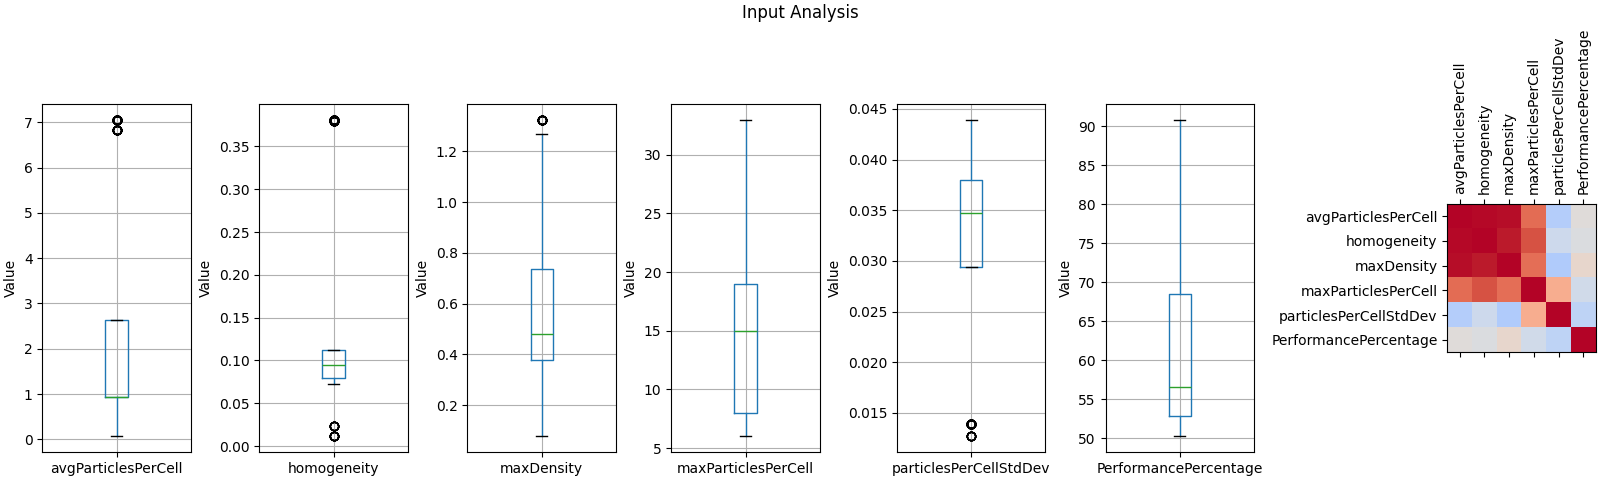

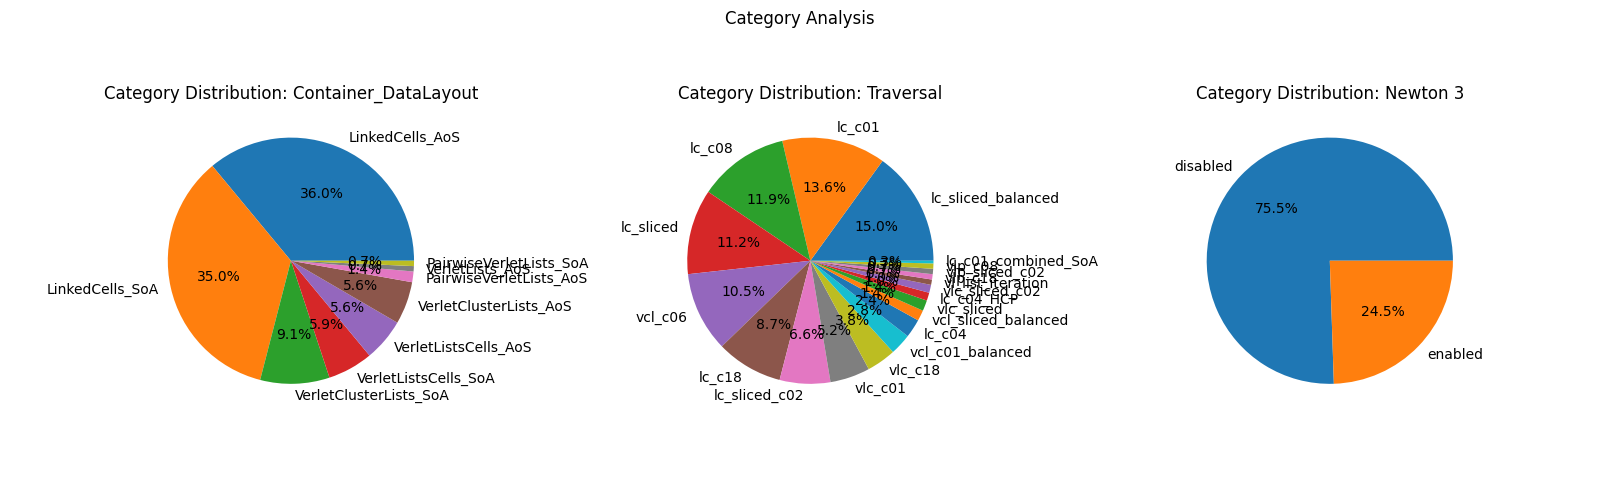

In [66]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)
for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()
    ax1[i].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [67]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.02,
    "Traversal": 0.02,
    "Data Layout": 0.02,
    "Newton 3": 0.02,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 3

Training on 228 samples
Number of rules 51:
	Container_DataLayout (17 rules)
	Traversal (27 rules)
	Newton 3 (7 rules)


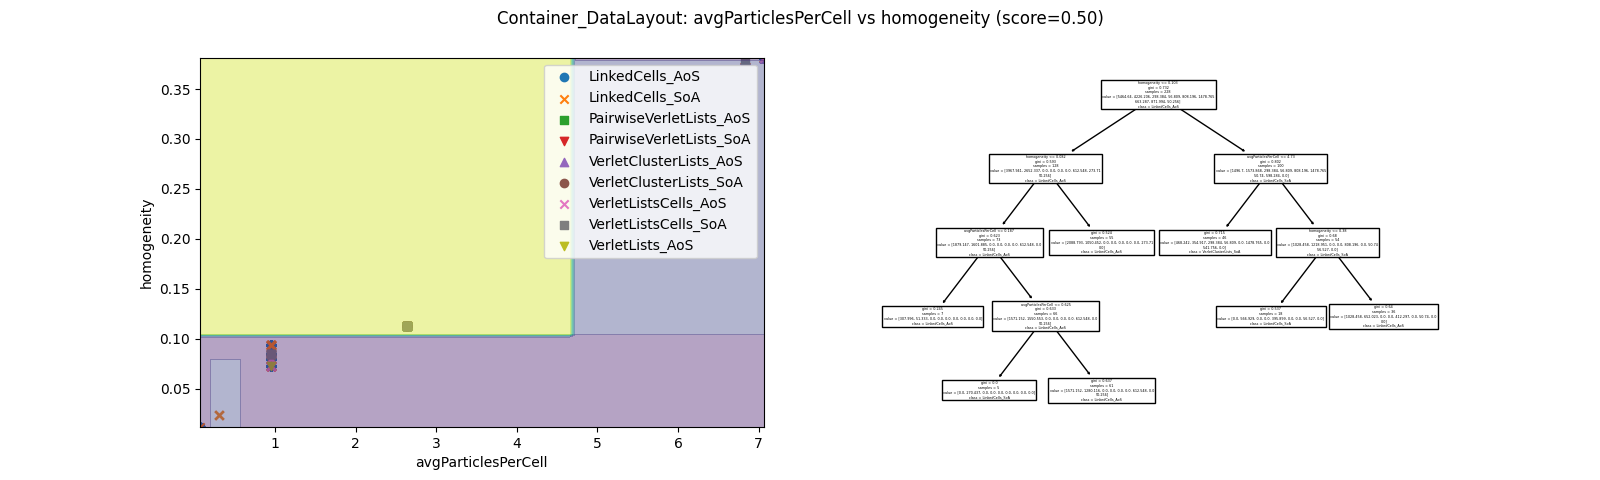

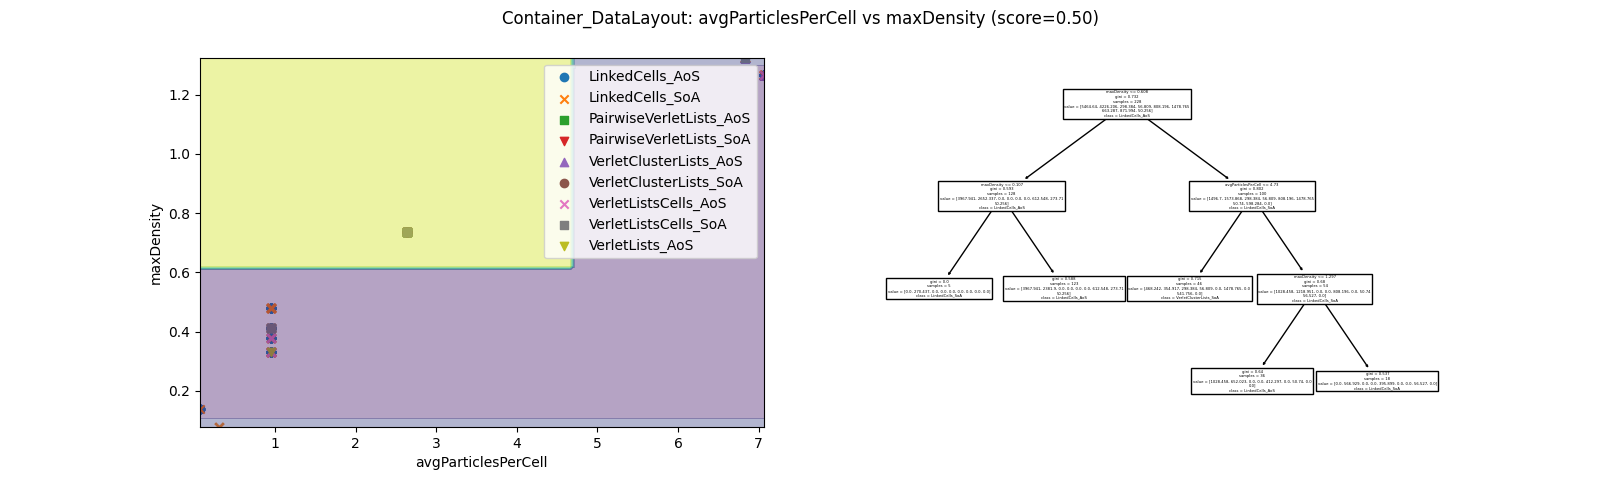

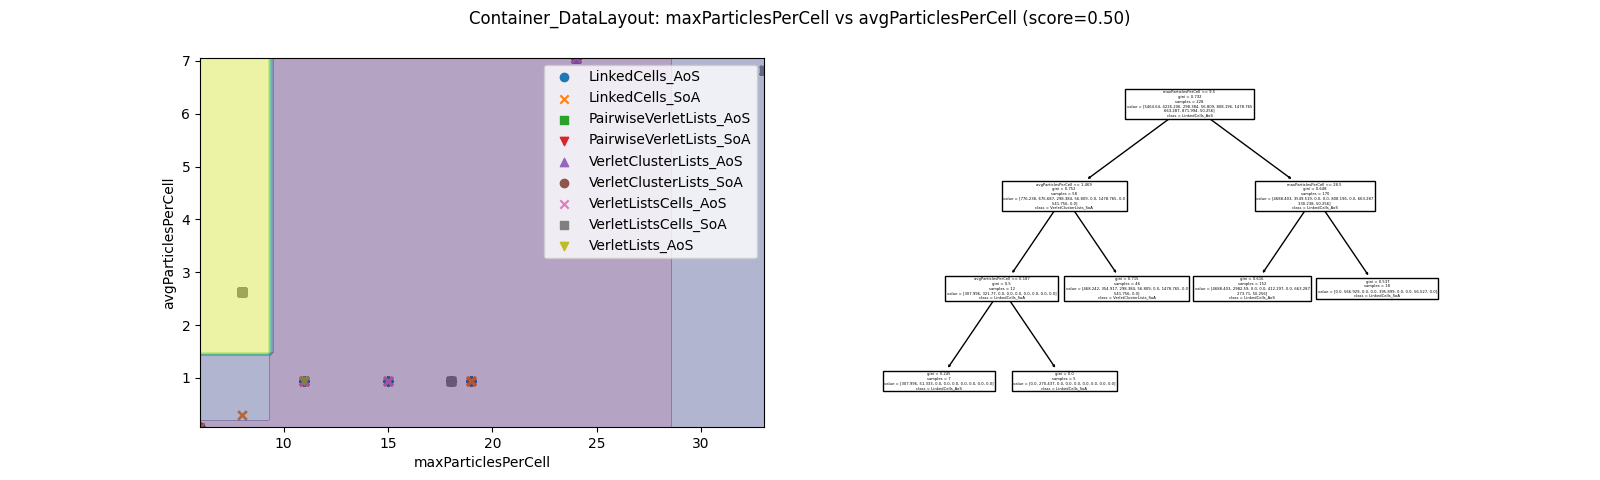

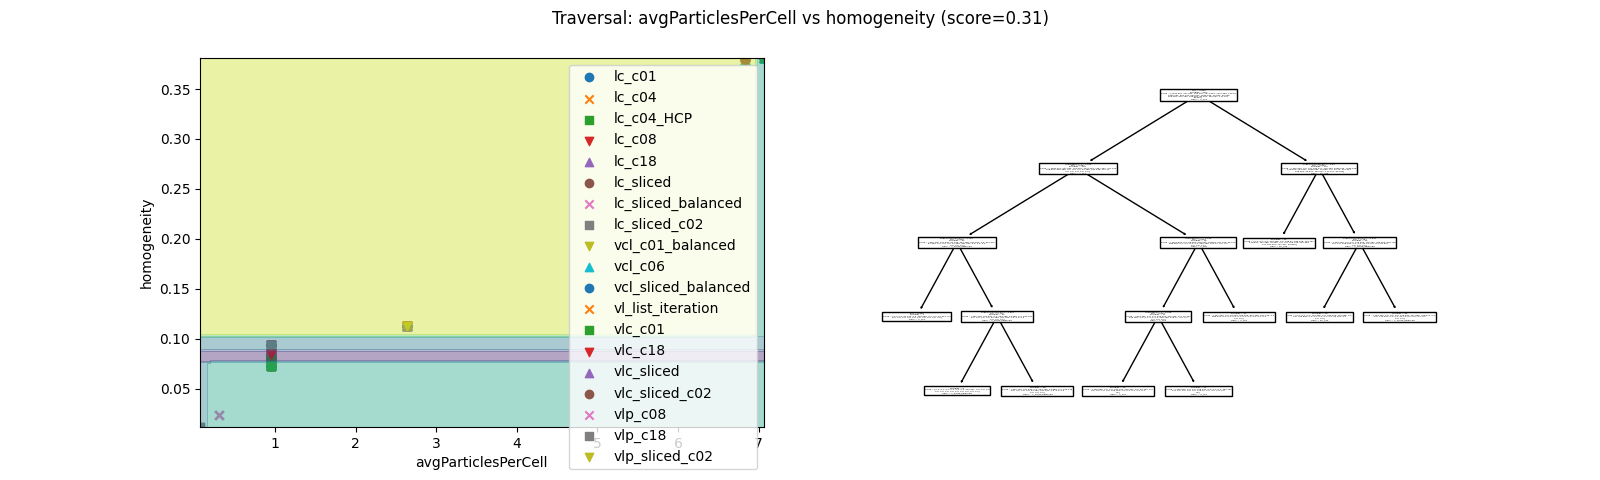

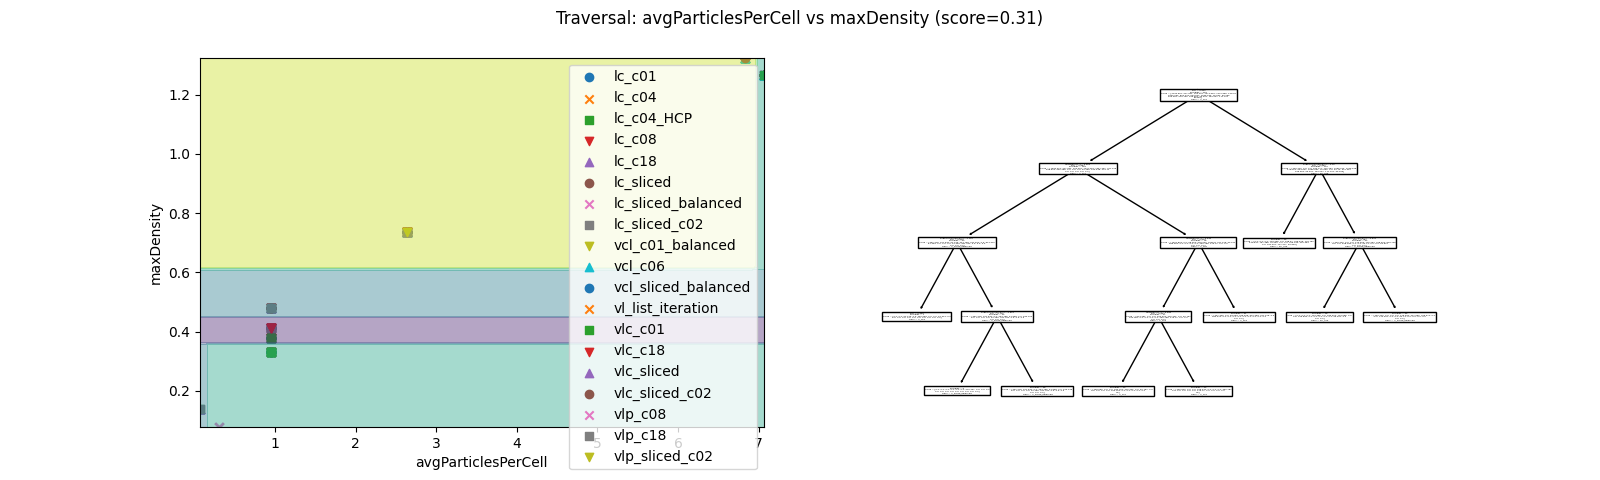

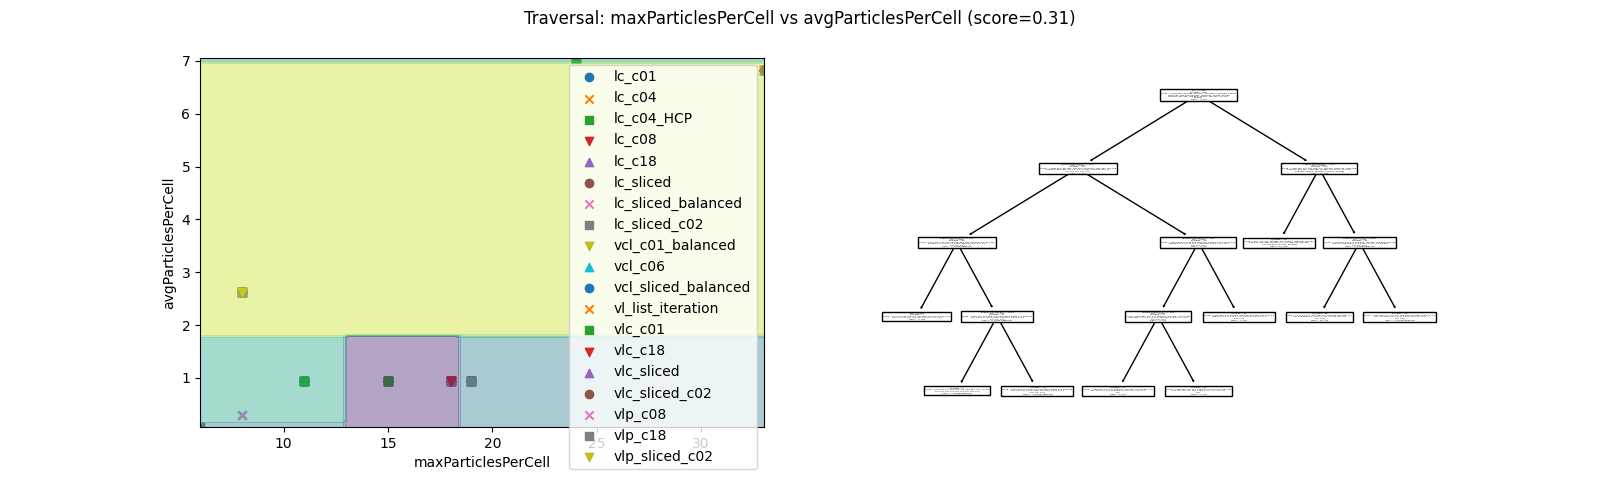

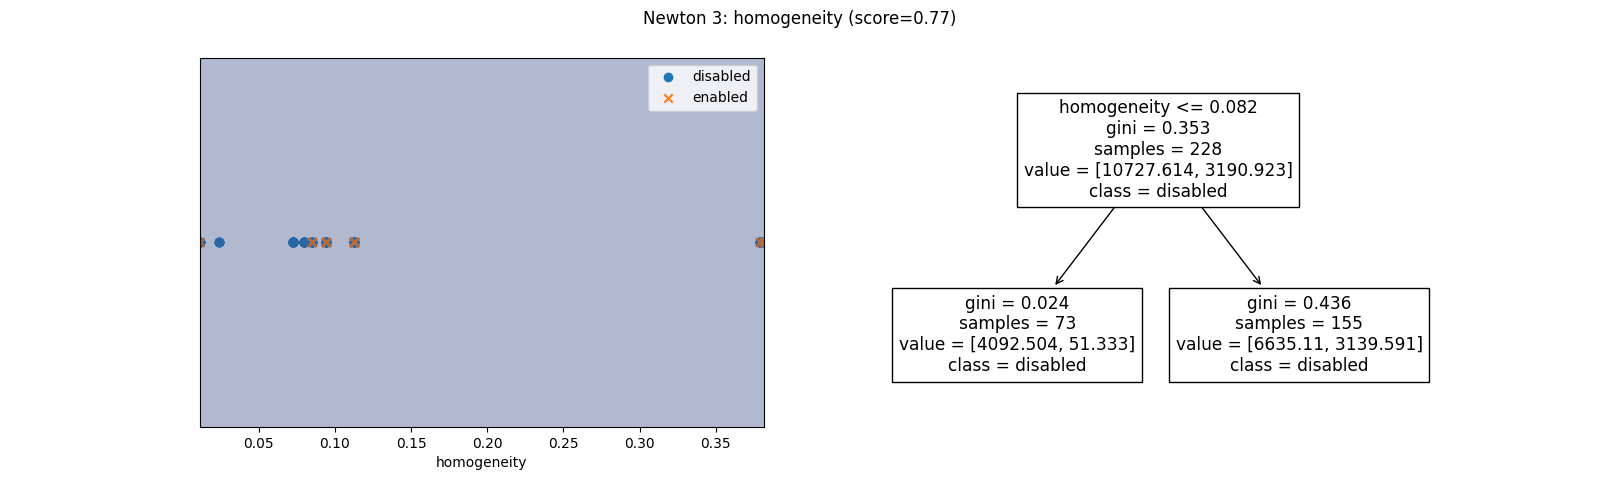

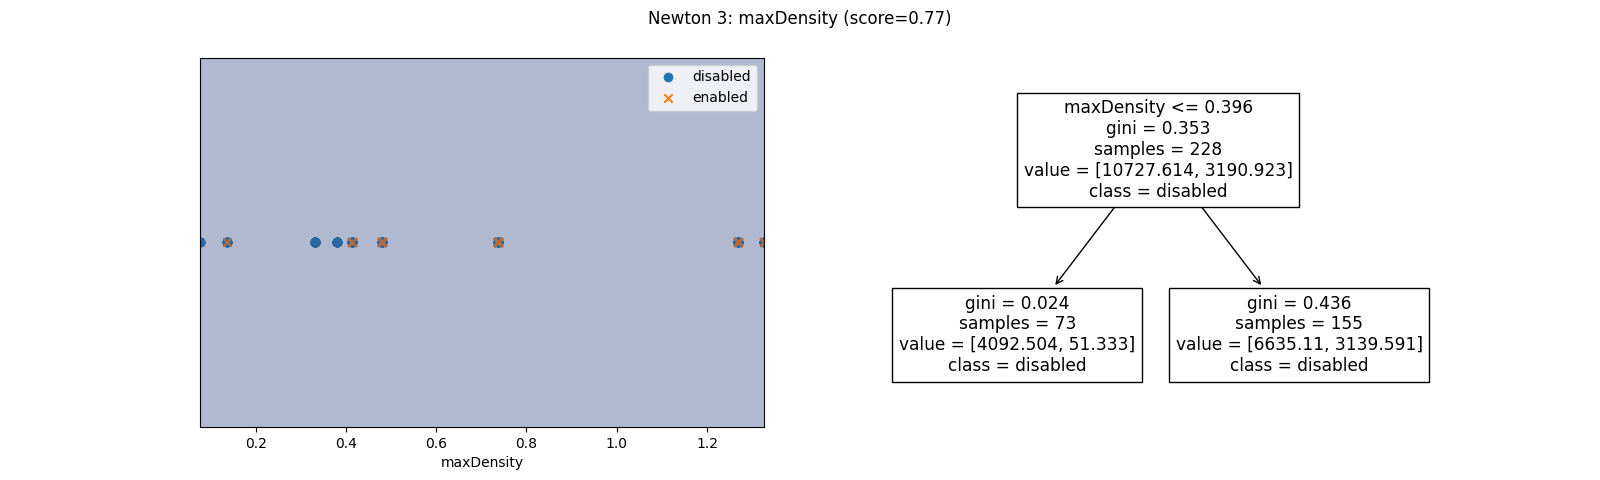

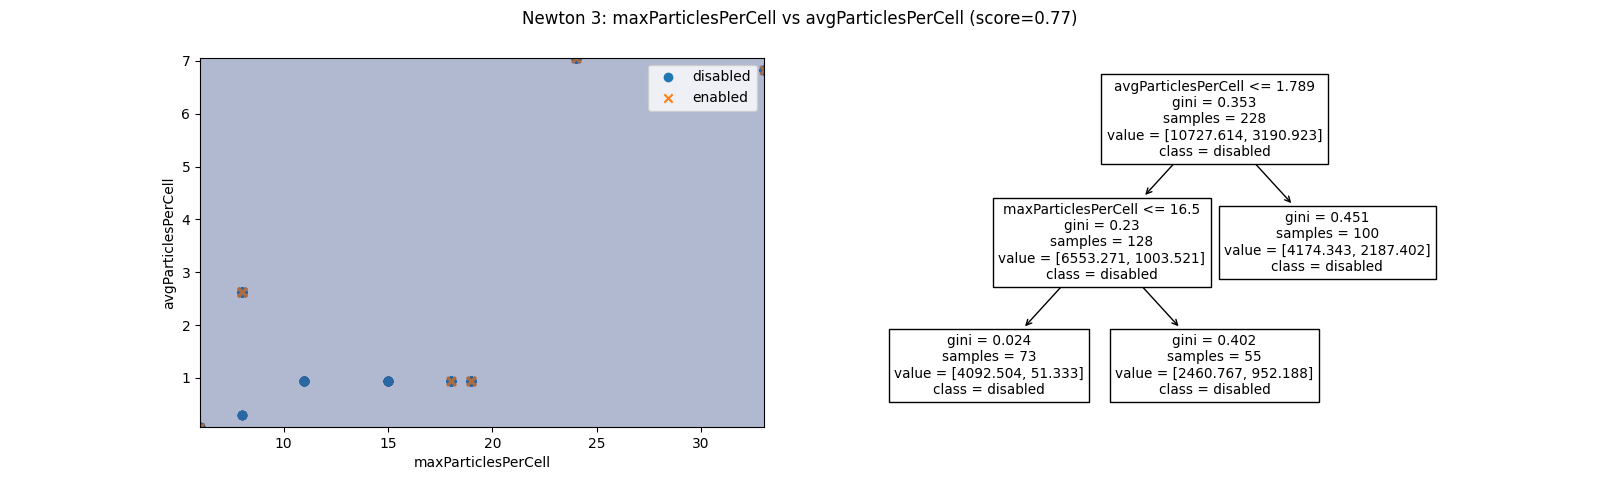

In [68]:
auto_rules = create_auto_rules(X_train, y_train,  X_train["PerformancePercentage"],
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL, ["PerformancePercentage"])

homogeneity: [-inf, 0.076, 0.082, 0.089, 0.103, 0.38, inf]
homogeneity: [-inf, 0.076, 0.103, 0.38, inf]

avgParticlesPerCell: [-inf, 0.187, 0.625, 1.469, 1.789, 4.73, 6.944, inf]
avgParticlesPerCell: [-inf, 0.187, 0.625, 1.469, 1.789, 4.73, 6.944, inf]

maxDensity: [-inf, 0.107, 0.355, 0.396, 0.446, 0.608, 1.297, inf]
maxDensity: [-inf, 0.107, 0.355, 0.446, 0.608, 1.297, inf]

maxParticlesPerCell: [-inf, 9.5, 13.0, 16.5, 18.5, 28.5, inf]
maxParticlesPerCell: [-inf, 9.5, 13.0, 16.5, 18.5, 28.5, inf]



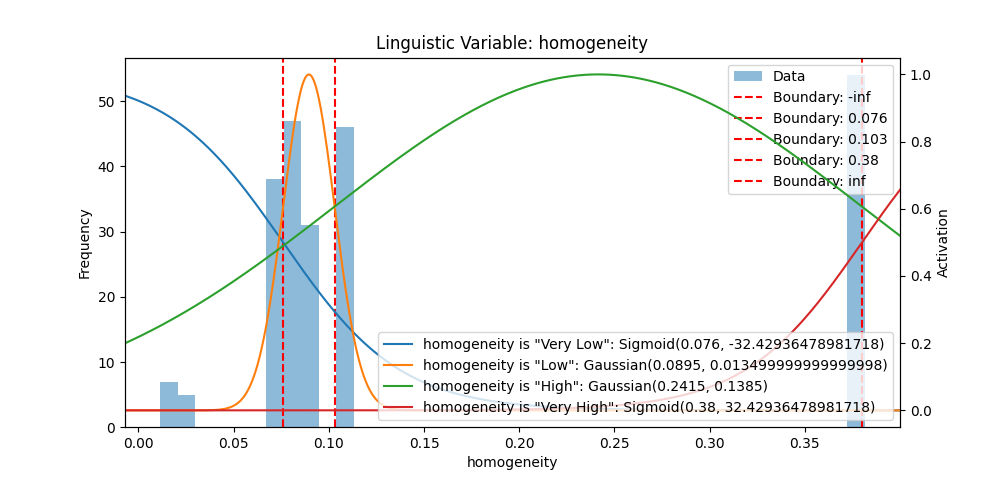

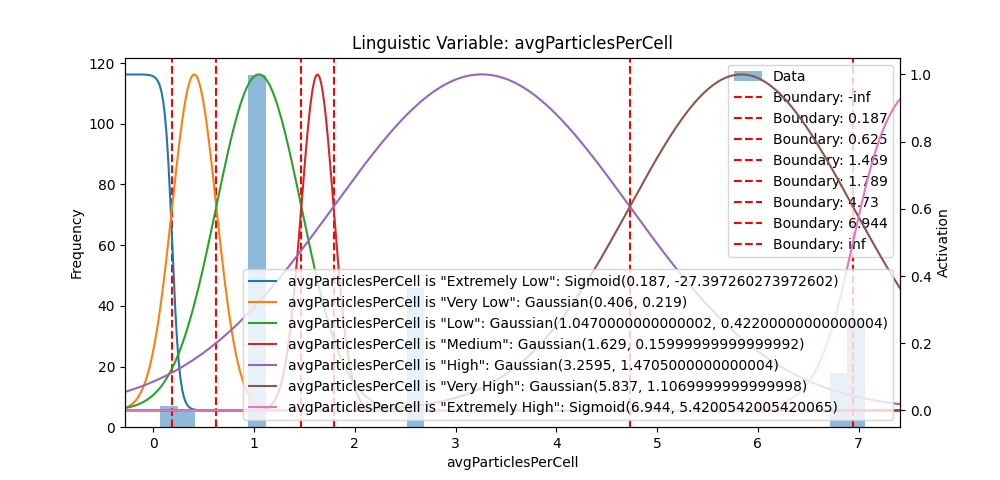

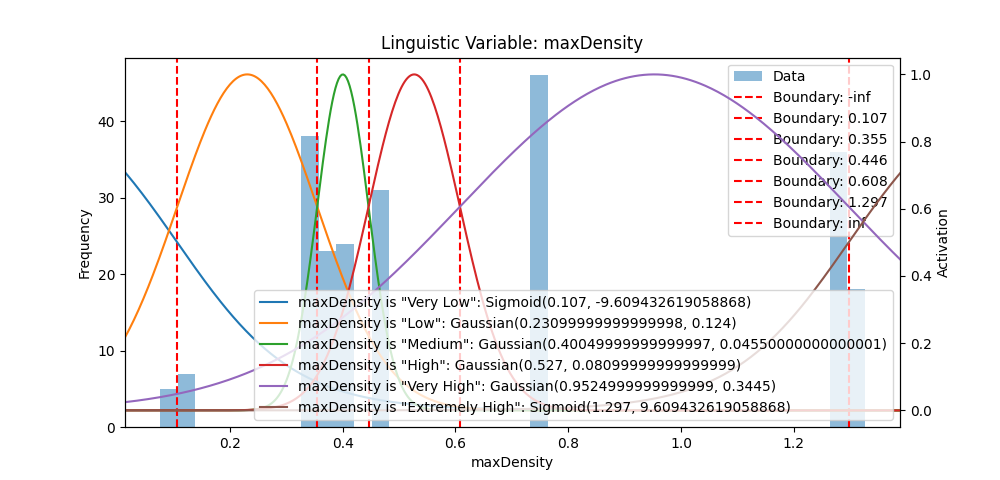

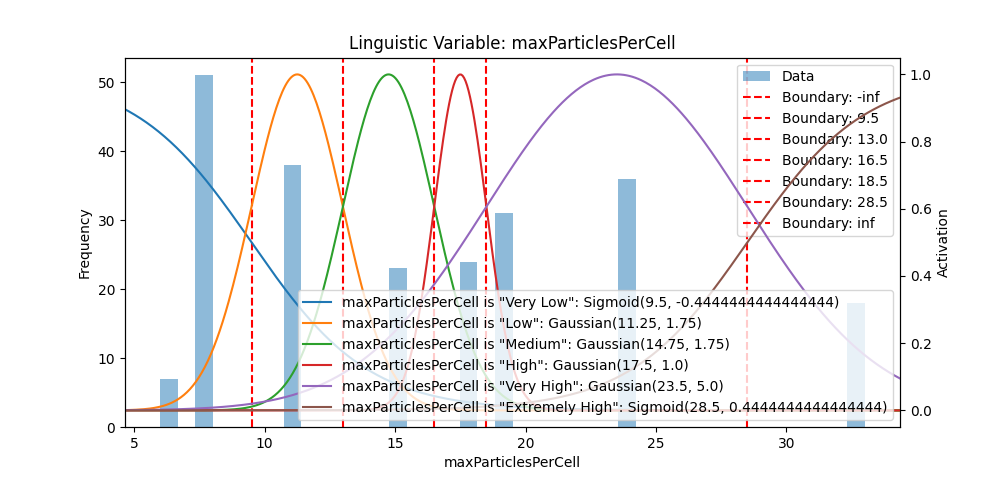

In [69]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


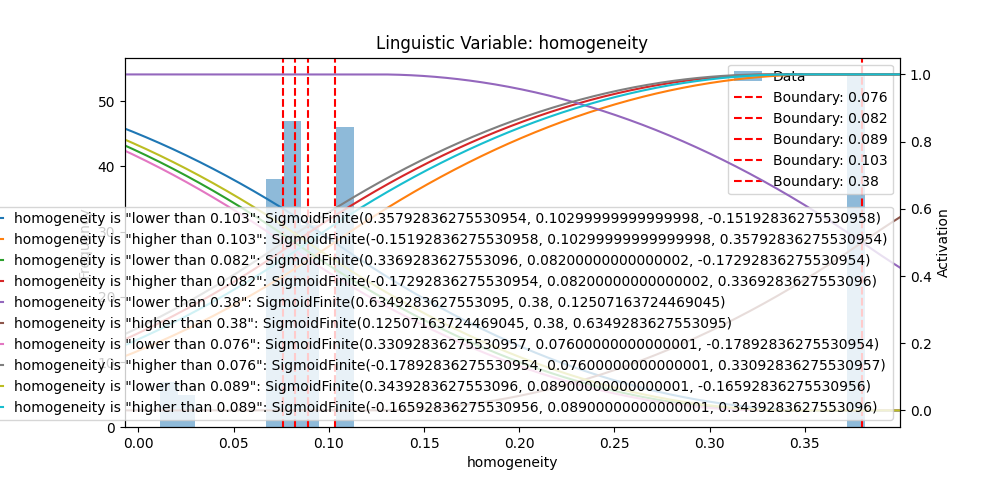

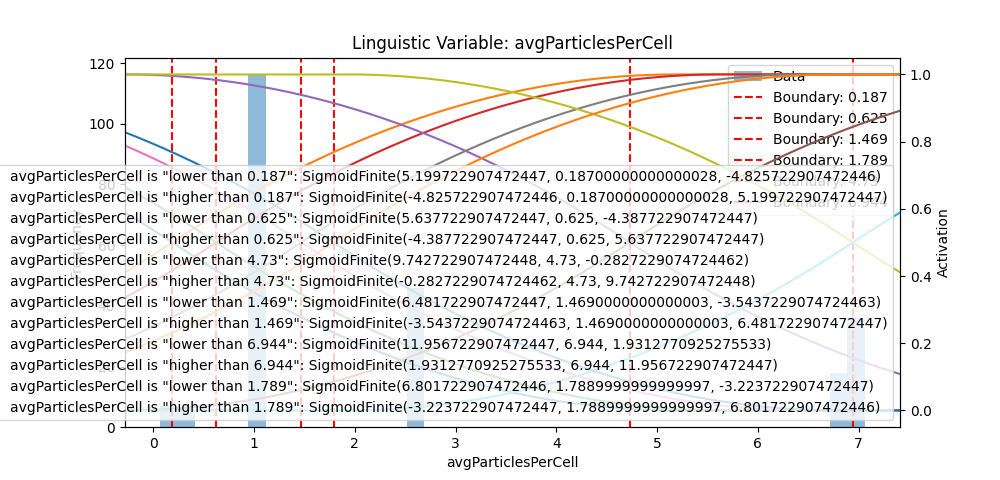

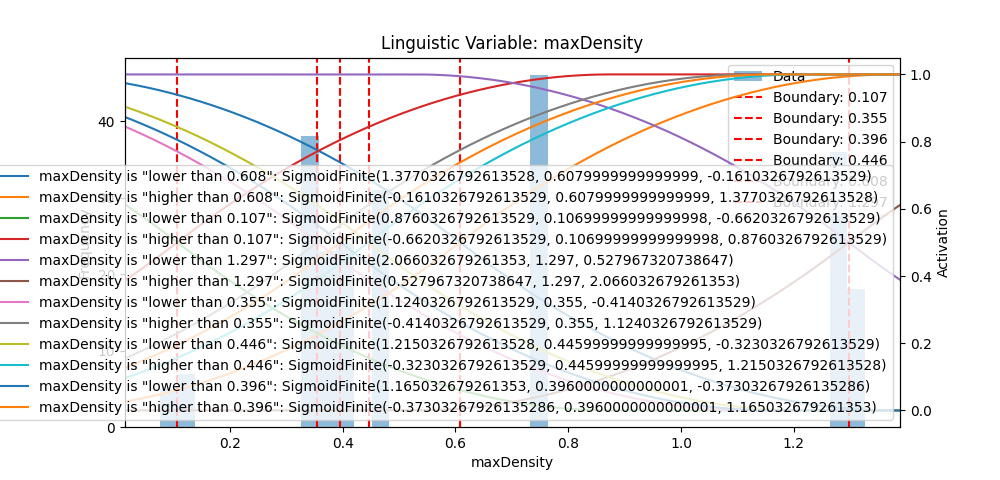

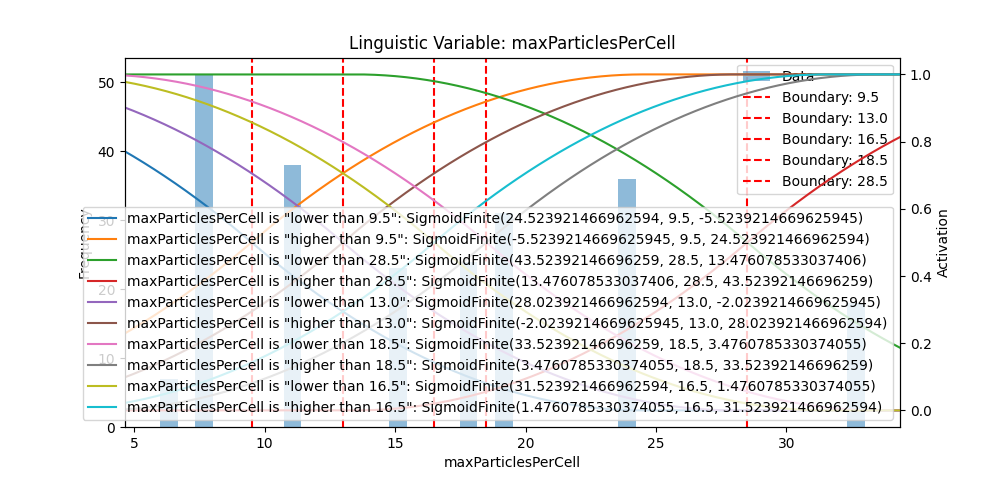

In [70]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

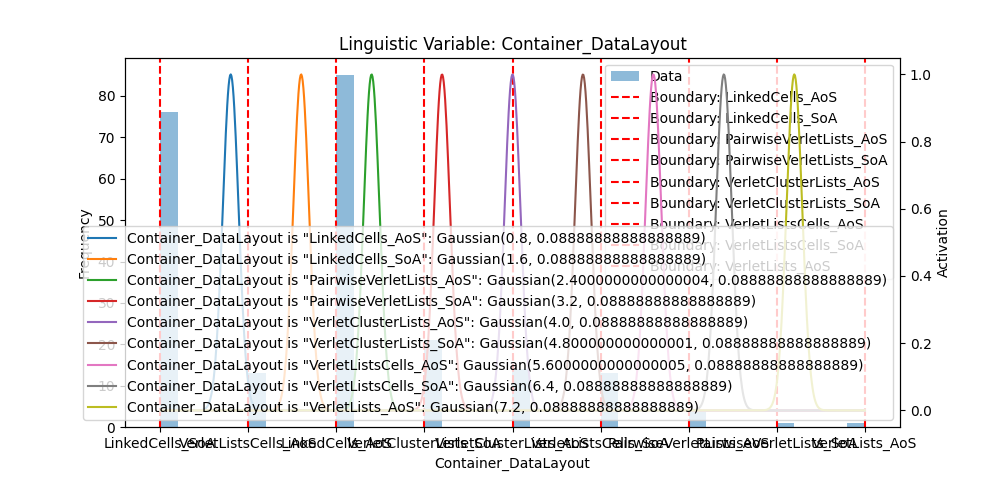

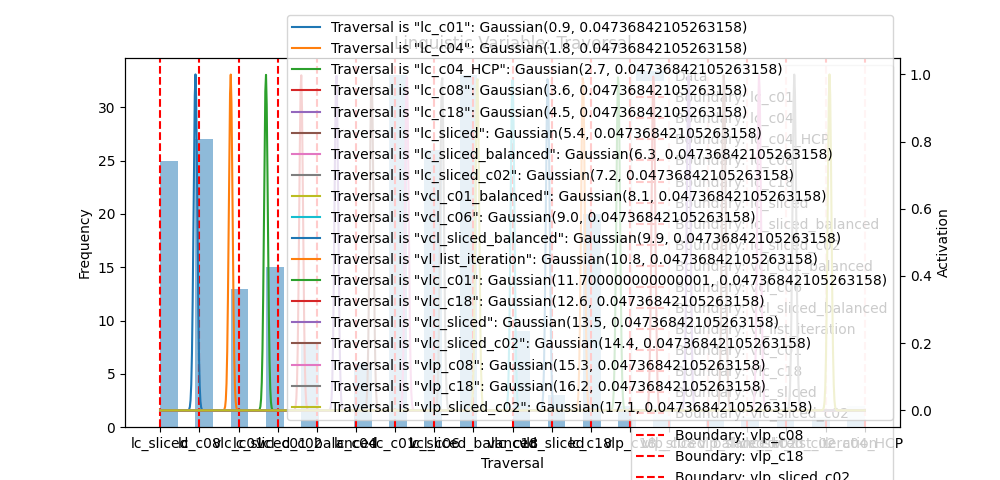

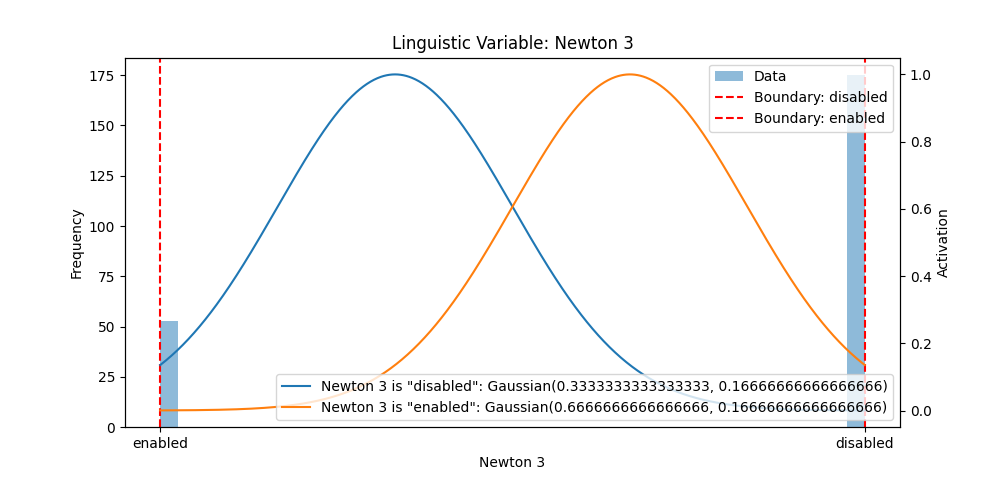

In [71]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [72]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "homogeneity" range: (-0.24350336275530957, 0.6363883627553095)
	"Very Low": Sigmoid(0.076, -32.42936478981718)
	"Low": Gaussian(0.0895, 0.013499999999999998)
	"High": Gaussian(0.2415, 0.1385)
	"Very High": Sigmoid(0.38, 32.42936478981718)

FuzzyVariable: domain: "avgParticlesPerCell" range: (-4.944332907472447, 12.074410907472448)
	"Extremely Low": Sigmoid(0.187, -27.397260273972602)
	"Very Low": Gaussian(0.406, 0.219)
	"Low": Gaussian(1.0470000000000002, 0.42200000000000004)
	"Medium": Gaussian(1.629, 0.15999999999999992)
	"High": Gaussian(3.2595, 1.4705000000000004)
	"Very High": Gaussian(5.837, 1.1069999999999998)
	"Extremely High": Sigmoid(6.944, 5.4200542005420065)

FuzzyVariable: domain: "maxDensity" range: (-0.6922326792613529, 2.0946056792613525)
	"Very Low": Sigmoid(0.107, -9.609432619058868)
	"Low": Gaussian(0.23099999999999998, 0.124)
	"Medium": Gaussian(0.40049999999999997, 0.04550000000000001)
	"High": Gaussian(0.527, 0.08099999999999999)
	"Very Hig